# 0.0 Understanding the Situation

- objective of the proposed situation
1. Prediction of the first destination a new user will choose
- Why?
 - What kind of business model does Airbnb have?
 - Market Place (connecting people who offer accommodation with people who are looking for accommodation)
 - Offer (people offer accommodation)
   - Portifolio size
   - Portfolio diversity/density
   - Average price
 - Demand (people looking for accommodation)
   - Number of Users
   - LTV (Lifetime Value)
   - CAC (Client Acquisition Cost)
 - Gross Revenue  = fee * number of users - CAC (contribution margins)
 
 
- **Solution**
 - Prediction model of the first destination of a new user
 - API
   - **Input**: user and its characteristics
   - **Output**: user and its characteristics **with the prediction of destination**

# 1.0 IMPORTS

## 1.1 Libraries

In [ ]:
#!pip install scikit-plot

In [1]:
import random
import pandas as pd  # pip install pandas
import numpy as np # pip install numpy
import seaborn as sns # pip install seaborn
from scipy import stats as ss
from sklearn.model_selection import train_test_split, StratifiedKFold  # pip install sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, classification_report
from scikitplot.metrics import plot_confusion_matrix  # pip install scikit-plot
from keras.models import Sequential  # pip install keras; pip install tensorflow
from keras.layers import Dense

## 1.2 Helper Functions

In [29]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

## 1.3 Loading data

In [3]:
!ls -l ../01-Data/csv_data

total 648652
-rw-r--r-- 1 fabio 197609     11905 Oct 16  2015 age_gender_bkts.csv
-rw-r--r-- 1 fabio 197609       632 Oct 16  2015 countries.csv
-rw-r--r-- 1 fabio 197609    931451 Dec  6  2015 sample_submission_NDF.csv
-rw-r--r-- 1 fabio 197609 631646292 Dec  6  2015 sessions.csv
-rw-r--r-- 1 fabio 197609   6763170 May 16  2018 test_users.csv
-rw-r--r-- 1 fabio 197609  24853881 Dec 10  2015 train_users_2.csv


### 1.3.1 Training

In [4]:
df_train_raw = pd.read_csv(
    "../01-Data/csv_data/train_users_2.csv", low_memory=True)
df_train_raw.shape

(213451, 16)

### 1.3.2 Sessions

In [5]:
df_sessions_raw = pd.read_csv(
    "../01-Data/csv_data/sessions.csv", low_memory=True)
df_sessions_raw.shape

(10567737, 6)

# 2.0 DATA DESCRIPTION

In [6]:
df_train_01 = df_train_raw.copy()
df_sessions_01 = df_sessions_raw.copy()

## 2.1 Data Dimensions

### 2.1.1 Training

In [7]:
print(f'Number of Rows: {df_train_01.shape[0]}')
print(f'Number of Columns: {df_train_01.shape[1]}')

Number of Rows: 213451
Number of Columns: 16


### 2.1.2 Sessions

In [8]:
print(f'Number of Rows: {df_sessions_01.shape[0]}')
print(f'Number of Columns: {df_sessions_01.shape[1]}')

Number of Rows: 10567737
Number of Columns: 6


## 2.2 Data Type

### 2.2.1 Training

In [9]:
df_train_01.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

### 2.2.2 Sessions

In [10]:
df_sessions_01.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 2.3 NA Check

### 2.3.1 Training

In [11]:
df_train_01.isnull().sum() / len(df_train_01)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [12]:
aux = df_train_01[df_train_01['date_first_booking'].isnull()]
aux['country_destination'].value_counts(normalize=True)

NDF    1.0
Name: country_destination, dtype: float64

In [13]:
aux = df_train_01[df_train_01['age'].isnull()]
aux['country_destination'].value_counts(normalize=True)

NDF      0.768428
US       0.156529
other    0.028617
FR       0.014888
IT       0.009081
GB       0.006251
ES       0.006171
CA       0.003989
DE       0.002387
NL       0.001818
AU       0.001171
PT       0.000671
Name: country_destination, dtype: float64

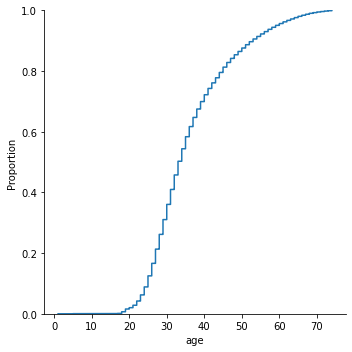

In [14]:
sns.displot(df_train_01[df_train_01['age']<75]['age'], kind='ecdf');

In [15]:
df_train_01['first_affiliate_tracked'].drop_duplicates()

0            untracked
5                  omg
12                 NaN
13              linked
79       tracked-other
257            product
6270         marketing
11184        local ops
Name: first_affiliate_tracked, dtype: object

In [16]:
# remove missing values completely
#df_train_01 = df_train_01.dropna()

# date_first_booking
date_first_booking_max = pd.to_datetime(df_train_01['date_first_booking']).max().strftime('%Y-%m-%d')
df_train_01['date_first_booking'] = df_train_01['date_first_booking'].fillna(date_first_booking_max)

# age
df_train_01 = df_train_01[(df_train_01['age'] > 15) & (df_train_01['age'] < 120)]
avg_age = int(df_train_01['age'].mean())
df_train_01['age'] = df_train_01['age'].fillna(avg_age)

# first_affiliate_tracked
# remove missing values completely
df_train_01 = df_train_01[~df_train_01['first_affiliate_tracked'].isnull()]

df_train_01.shape

(122636, 16)

### 2.3.2 Sessions

In [17]:
df_sessions_01.isnull().sum() / len(df_sessions_01)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [18]:
# remove missing values completely
## user_id - 0.3%
df_sessions_01 = df_sessions_01[~df_sessions_01['user_id'].isnull()]

## action - 0.75%
df_sessions_01 = df_sessions_01[~df_sessions_01['action'].isnull()]

## action_type - 10.65%
df_sessions_01 = df_sessions_01[~df_sessions_01['action_type'].isnull()]

## action_detail - 10.65%
df_sessions_01 = df_sessions_01[~df_sessions_01['action_detail'].isnull()]

## secs_elapsed - 1.3%
df_sessions_01 = df_sessions_01[~df_sessions_01['secs_elapsed'].isnull()]

df_sessions_01.shape

(9213930, 6)

## 2.4 Change Data type 

### 2.4.1 Training

In [19]:
# date_account_created
df_train_01['date_account_created'] = pd.to_datetime(
    df_train_01['date_account_created'])
# timestamp_first_active
df_train_01['timestamp_first_active'] = pd.to_datetime(
    df_train_01['timestamp_first_active'], format='%Y%m%d%H%M%S')
# date_first_booking
df_train_01['date_first_booking'] = pd.to_datetime(
    df_train_01['date_first_booking'])

# age
df_train_01['age'] = df_train_01['age'].astype(int)

In [20]:
df_train_01.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 2.5 Check Balanced Data

### 2.5.1 Training

In [21]:
df_train_01['country_destination'].value_counts(normalize=True)

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 2.6 Descriptive Analysis

### 2.6.1 General

In [22]:
## Users
num_attributes = df_train_01.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes = df_train_01.select_dtypes(exclude=['int32','int64', 'float64', 'datetime64[ns]'])
time_attributes = df_train_01.select_dtypes(include=['datetime64[ns]'])

## Sessions
num_attributes_sessions = df_sessions_01.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes_sessions = df_sessions_01.select_dtypes(exclude=['int32','int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df_sessions_01.select_dtypes(include=['datetime64[ns]'])

### 2.6.2 Numerical Users

In [23]:
# Central Tendency - Mean, Mediam
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                  
# Concatenate
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


### 2.6.3 Numerical Sessions

In [24]:
# Central Tendency - Mean, Mediam
ct1 = pd.DataFrame(num_attributes_sessions.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes_sessions.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes_sessions.apply(np.std)).T
d2 = pd.DataFrame(num_attributes_sessions.apply(min)).T
d3 = pd.DataFrame(num_attributes_sessions.apply(max)).T
d4 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis())).T

# Concatenate
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 2.6.3 Categorical Users

In [25]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 2.6.4 Categorical Sessions

In [26]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [30]:
# list of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        
        # append list
        corr_list.append(corr)
        
    # append correlation list for each ref attributes  
    corr_dict[ref] = corr_list
    
#d = pd.DataFrame(corr_dict)

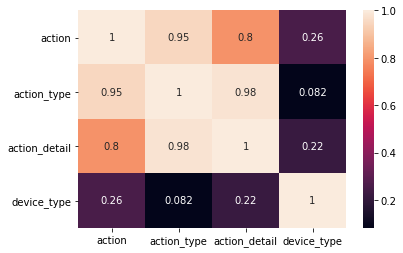

In [31]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# 3.0 Feature Engineering

In [ ]:
df_train_02 = df_train_01.copy()
df_sessions_02 = df_sessions_01.copy()

In [ ]:
# days from first activate up to first booking
df_train_02['first_active'] = pd.to_datetime(df_train_02['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
df_train_02['days_from_first_active_until_booking'] = (df_train_02['date_first_booking'] - df_train_02['first_active']).apply(lambda x: x.days)

# days from first activate up to account created
df_train_02['days_from_first_active_until_account_created'] = (df_train_02['date_account_created'] - df_train_02['first_active']).apply(lambda x: x.days)

# days from account created up to first booking


# days from 

# 4.0 Data Filtering

In [ ]:
df_train_03 = df_train_02.copy()
df_sessions_03 = df_sessions_02.copy()

## 4.1 Filtering Rows

In [ ]:
# Filtering rows:
## age > greater than 15 and lower than 120 - There are few people over 120 years old
df_train_03 = df_train_03[(df_train_03['age'] > 15) & (df_train_03['age'] < 120)]

## secs_elapsed > greater than 0 - There is no possible secs elepsed on website
df_sessions_03 = df_sessions_03[df_sessions_03['secs_elapsed'] > 0]

# 5.0 Data Preparation

In [ ]:
df_train_04 = df_train_03.copy()

In [ ]:
# Dummy variable
df_train_04_dummy = pd.get_dummies(
    df_train_04.drop(['id', 'country_destination'], axis=1))

# Join id and country_destination
df_train_04 = pd.concat(
    [df_train_04[['id', 'country_destination']], df_train_04_dummy], axis=1)

# 6.0 Feature Selection

## 6.1 Drop Columns

In [ ]:
cols_drop = [
    'date_account_created', 'timestamp_first_active', 'date_first_booking',
    'id'
]  # orginal dates
df_train_05 = df_train_04.drop(cols_drop, axis=1)

## 6.2 Split into Train and Validation 

In [ ]:
X = df_train_05.drop('country_destination', axis=1)
y = df_train_05['country_destination'].copy()

# Split dataset into train and validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=32)

# 7.0 Machine Learning Model

## 7.1 Baseline model

### 7.1.1 Random Choices

In [ ]:
country_destination_list = y_train.drop_duplicates().sort_values().tolist()
country_destination_weights = y_train.value_counts(
    normalize=True).sort_index().tolist()
k_num = y_test.shape[0]

# Random Model

yhat_random = random.choices(population=country_destination_list,
                             weights=country_destination_weights,
                             k=k_num)

### 7.1.2 Random Choices Performance

In [ ]:
# Accuracy
acc_random = accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Score
kappa_random = cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification Report
print(classification_report(y_test, yhat_random))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12, 12))

## 7.2 Machine Learning Model - Neural Network MLP

### 7.2.1 Target Encoding

In [ ]:
ohe = OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

### 7.2.2 NN Model

In [ ]:
# Model Definition
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(11, activation='softmax'))

# Model compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

# Train Model
model.fit(X_train, y_train_nn, epochs=100)

### 7.2.3 NN Performance

In [ ]:
# Prediction
pred_nn = model.predict(X_valid)

# Inver Prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# Prediction Prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

In [ ]:
# Accuracy
acc_nn = accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuracy
balanced_acc_nn = balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Score
kappa_nn = cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification Report
print(classification_report(y_test_nn, yhat_nn))

# Confusion matrix
plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12, 12))

### 7.2.4 NN Performance - Cross Validation

In [ ]:
# k-fold generate
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(X_train, y_train):
    print('Fold Number: {}/{}'.format(i, num_folds))
    # get fold
    X_train_fold = X_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    X_val_fold = X_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target encoding
    ohe = OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()
    
    # model definition
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_fold.shape[1], activation='relu'))
    model.add(Dense(11, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # training model
    model.fit(X_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)

    # prediction
    pred_nn = model.predict(X_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn)
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]

    # metrics
    ## Balanced Accuracy
    balanced_acc_nn = balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    ## Kappa Metrics
    kappa_acc_nn = cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
    
    i+=1

In [ ]:
print('Avg Balanced Accuracy: {} +/- {}'.format(np.round(np.mean(balanced_acc_list),4), np.round(np.std(balanced_acc_list),4)))
print('Avg Kappa: {} +/- {}'.format(np.round(np.mean(kappa_acc_list),4), np.round(np.std(kappa_acc_list),4)))